In [1]:
PROJECT_NAME = 'ANIME-DCGAN'

In [2]:
import os 

In [3]:
DATA_DIR = './animeDataset'
DATASET_IMAGES_PATH = '/images'
print(f"Ten Images from Dataset: {os.listdir(DATA_DIR + DATASET_IMAGES_PATH)[:10]}")
print(f"Total Images in Dataset: {len(os.listdir(DATA_DIR + DATASET_IMAGES_PATH))}")

Ten Images from Dataset: ['0_2000.jpg', '10000_2004.jpg', '10001_2004.jpg', '10002_2004.jpg', '10003_2004.jpg', '10004_2004.jpg', '10005_2004.jpg', '10006_2004.jpg', '10007_2004.jpg', '10008_2004.jpg']
Total Images in Dataset: 63565


In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [5]:
IMAGE_SIZE = 64
BATCH_SIZE = 128
STATS = (.5, .5, .5), (.5, .5, .5)

In [6]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(IMAGE_SIZE), 
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(), 
    T.Normalize(*STATS)
]))
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

In [7]:
import torch
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
def denorm(img_tensor):
    return img_tensor * STATS[1][0] + STATS[0][0]

In [9]:
def showImages(images, nmax=64, save=False, title=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    if save and title:
        fig.savefig(f'{title}.png')

def showBatch(dl, nmax=64):
    for images, _ in dl:
        showImages(images, nmax, save=True, title="Anime-Dataset-Images")
        break

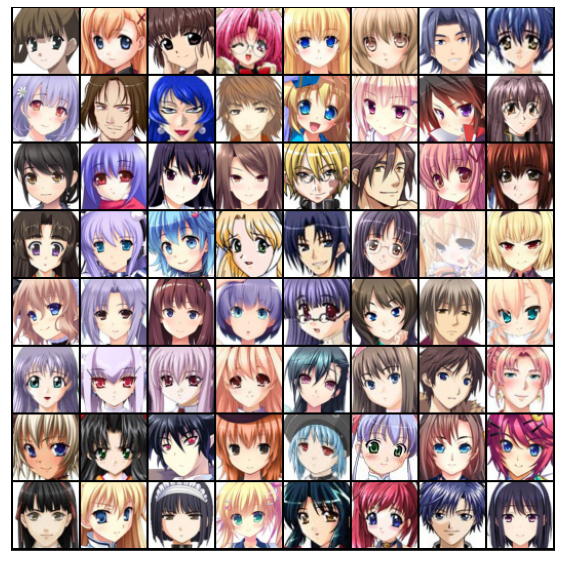

In [10]:
showBatch(train_dl)

In [11]:
# !pip install jovian --upgrade --quiet

In [12]:
# import jovian

In [13]:
# jovian.commit(project=PROJECT_NAME, environment=None, filename='anime-gan.ipynb')

In [14]:
# Using GPU 

def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [15]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

In [18]:
# Model

In [19]:
import torch.nn as nn

In [20]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4
    
    nn.Conv2d(512, 1,  kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid()
)

In [21]:
discriminator = to_device(discriminator, device)

In [22]:
LATENT_SIZE = 128

In [23]:
generator  = nn.Sequential(
    # in: LATENT_SIZE x 1 x 1
    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


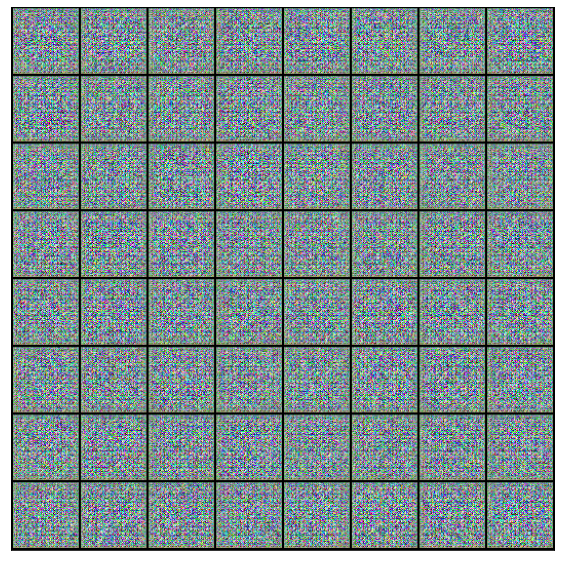

In [24]:
xb = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
showImages(fake_images, save=True, title='initial-generation')

In [25]:
generator = to_device(generator, device)

In [26]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score 

In [27]:
def train_generator(opt_g):
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = generator(latent)

    #Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(BATCH_SIZE, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [28]:
from torchvision.utils import save_image

In [29]:
sample_dir = 'Generated'
os.makedirs(sample_dir, exist_ok=True)

In [30]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving", fake_fname)
    if show:
        fig, ax = plt.subplots(figsize = (12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [31]:
fixed_latent = torch.randn(64, LATENT_SIZE, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


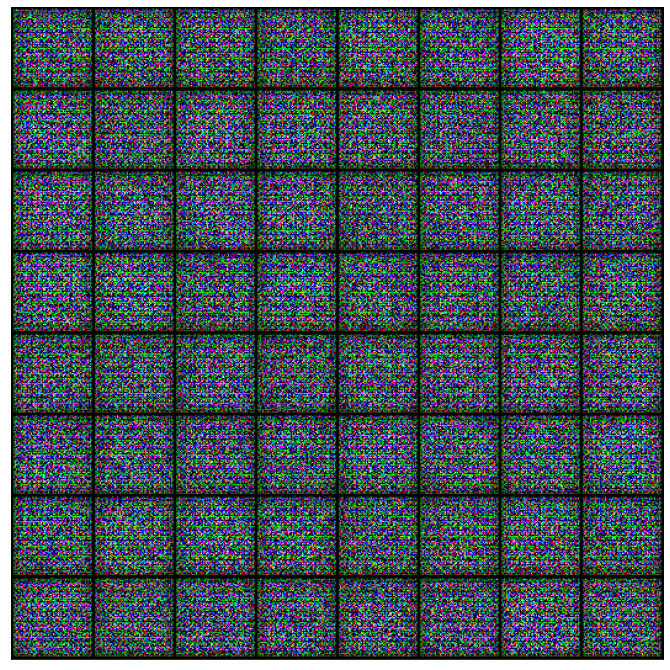

In [32]:
save_samples(0, fixed_latent)

In [33]:
import jovian

In [68]:
jovian.commit(project=PROJECT_NAME, environment=None, filename='anime-gan.ipynb')

<IPython.core.display.Javascript object>

[jovian] Updating notebook "hemanthhari2000/anime-dcgan" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/hemanthhari2000/anime-dcgan


'https://jovian.ai/hemanthhari2000/anime-dcgan'

In [69]:
# Full Training Loop

In [34]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [35]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    #Losses and Scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator 
            loss_d, real_score, fake_score = train_discriminator(real_images=real_images, opt_d=opt_d)
            loss_g = train_generator(opt_g=opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save Generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    return losses_g, losses_d, real_scores, fake_scores

In [36]:
lr = 0.0002
epochs = 25

In [34]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [37]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 4.7673, loss_d: 0.8039, real_score: 0.5469, fake_score: 0.0188
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 4.2196, loss_d: 0.4510, real_score: 0.7716, fake_score: 0.1284
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 4.4299, loss_d: 0.0860, real_score: 0.9322, fake_score: 0.0107
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 7.0219, loss_d: 0.2541, real_score: 0.9411, fake_score: 0.1515
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.2912, loss_d: 0.2221, real_score: 0.8512, fake_score: 0.0239
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.6159, loss_d: 0.1840, real_score: 0.9042, fake_score: 0.0503
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 16.7606, loss_d: 1.1168, real_score: 0.9974, fake_score: 0.5888
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 5.3948, loss_d: 0.1338, real_score: 0.9310, fake_score: 0.0358
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 5.3754, loss_d: 0.0668, real_score: 0.9479, fake_score: 0.0088
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 6.6859, loss_d: 0.1444, real_score: 0.9598, fake_score: 0.0882
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 11.0733, loss_d: 0.1063, real_score: 0.9185, fake_score: 0.0007
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 5.7780, loss_d: 0.0548, real_score: 0.9855, fake_score: 0.0374
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.7628, loss_d: 0.0367, real_score: 0.9818, fake_score: 0.0172
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 5.9258, loss_d: 0.0938, real_score: 0.9625, fake_score: 0.0456
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 5.4525, loss_d: 0.0772, real_score: 0.9617, fake_score: 0.0334
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.7679, loss_d: 0.1610, real_score: 0.8895, fake_score: 0.0039
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 11.7098, loss_d: 0.1643, real_score: 0.8774, fake_score: 0.0002
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 9.5638, loss_d: 0.1862, real_score: 0.9677, fake_score: 0.1137
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 6.0893, loss_d: 0.1212, real_score: 0.9249, fake_score: 0.0030
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 6.0518, loss_d: 0.0846, real_score: 0.9707, fake_score: 0.0435
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 11.8790, loss_d: 0.0872, real_score: 0.9475, fake_score: 0.0002
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 5.6970, loss_d: 0.0222, real_score: 0.9899, fake_score: 0.0112
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.7156, loss_d: 0.0297, real_score: 0.9887, fake_score: 0.0169
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 22.3076, loss_d: 0.4933, real_score: 0.9873, fake_score: 0.3401
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 19.3437, loss_d: 0.0344, real_score: 0.9987, fake_score: 0.0293
Saving generated-images-0025.png


In [38]:
# get number of GPU device connected
torch.cuda.device_count() 

1

In [39]:
losses_g, losses_d, real_scores, fake_scores = history

In [58]:
import json

metrics = {
    'loss_g': losses_g[-1], 
    'loss_d': losses_d[-1],
    'real_scores': 0.9987,
    'fake_scores': fake_scores[-1]
}
with open('metrics-1.json', 'w') as jsonFile:
    json.dump(metrics, jsonFile)

In [59]:
MODEL_DIR = 'model'
os.makedirs(MODEL_DIR, exist_ok=True)

In [64]:
os.makedirs(MODEL_DIR + '/second_pass', exist_ok=True)

In [65]:
# SAVE the model checkpoints
torch.save(generator.state_dict(),  './model/first_pass/generator.pth')
torch.save(discriminator.state_dict(), './model/first_pass/discriminator.pth')

In [66]:
from IPython.display import Image

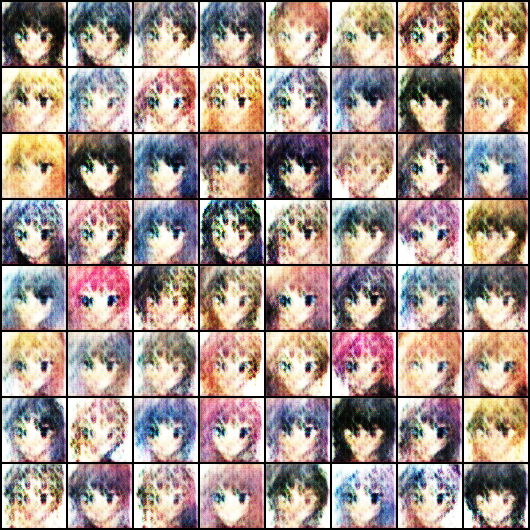

In [67]:
Image('./Generated/generated-images-0001.png')

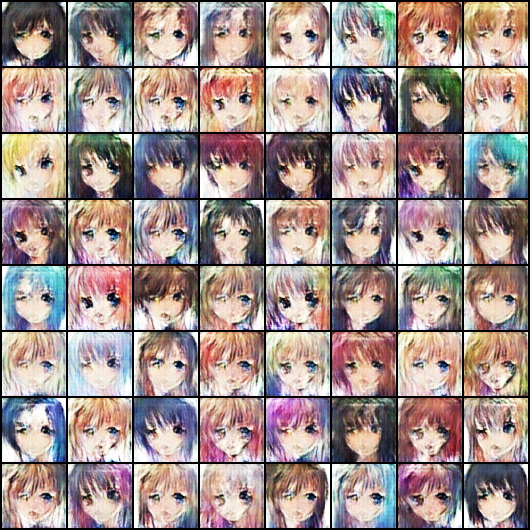

In [68]:
Image('./Generated/generated-images-0005.png')

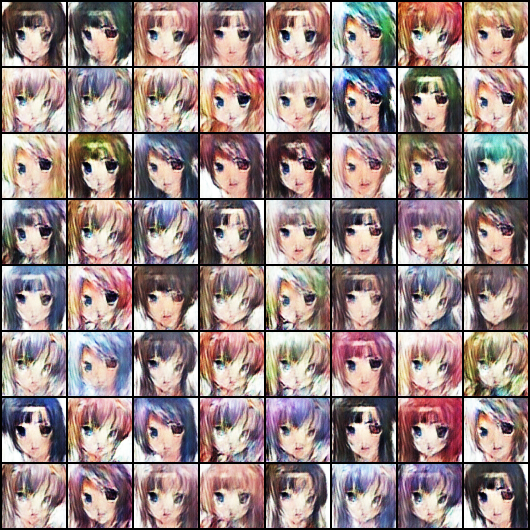

In [69]:
Image('./Generated/generated-images-0010.png')

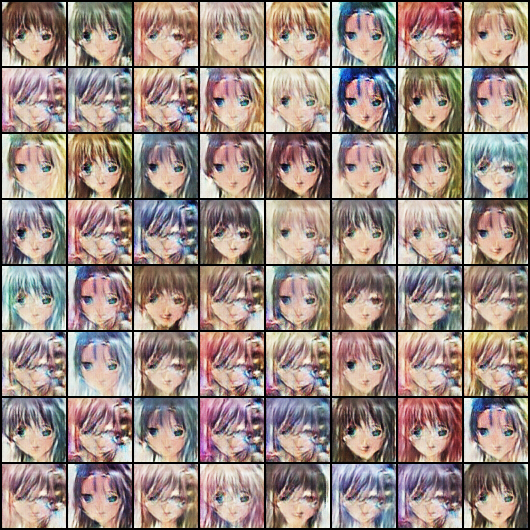

In [70]:
Image('./Generated/generated-images-0015.png')

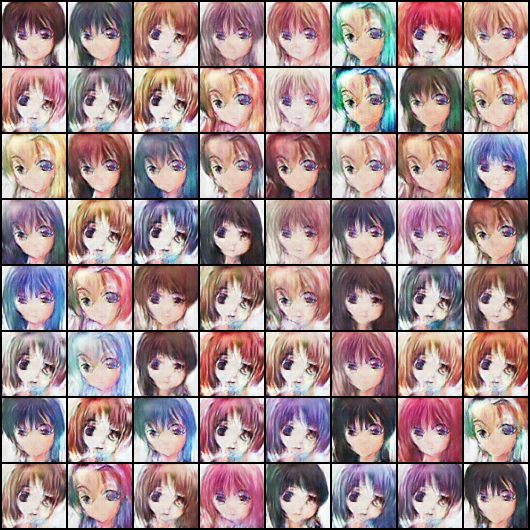

In [71]:
Image('./Generated/generated-images-0020.png')

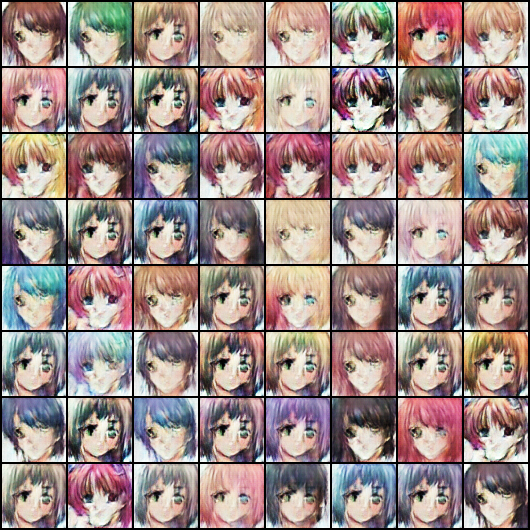

In [72]:
Image('./Generated/generated-images-0025.png')

In [73]:
#generate video sequence

import cv2
import os

In [74]:
vid_fname= 'gans-training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530, 530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

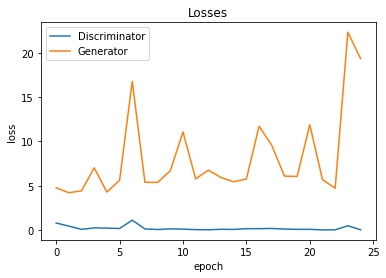

In [76]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');